# Script to produce Fig. 5

## Load packages

In [83]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy as crt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import geopandas
import regionmask

## Settings and folder paths

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=3.5)

idir = r'C:\Users\muis\OneDrive - Stichting Deltares\Desktop\paper_gtsmip\data'
idir2 = r'C:\Users\muis\OneDrive - Stichting Deltares\Desktop\paper_gtsmip\paper\R2\submitted\R3\scripts\data'
models = ['EC-Earth3P-HR','HadGEM3-GC31-HM-SST','GFDL-CM4C192-SST','CMCC-CM2-VHR4','HadGEM3-GC31-HM']
periods = ['1951-1980','1985-2014','2021-2050']
rp = 10

## Load data and store in single DataFrame 

In [3]:
# bedlevel
ifile = 'data/bedlevel.nc'
ds_bedlevel = xr.open_dataset(ifile)
pxyn = ds_bedlevel.to_dataframe()

# HighResMIP
df_models = []
for model, period in itertools.product(models, periods):   
    sim = 'future' if period == '2021-2050' else 'historical'
    nc_file = os.path.join(idir,'%s_%s_surge_actual-value_%s_rp%s_best-fit_v1.nc' % (str(model),str(sim),str(period),str(rp)))    
    ds_model = xr.open_dataset(nc_file)
    df_model = ds_model['return_mean_surge_level'].to_dataframe()
    df_model.rename(columns={df_model.columns[2]: '%s_%s' % (model,period)}, inplace = True)
    df_model.drop(columns=['station_x_coordinate','station_y_coordinate'],inplace=True)
    df_models.append(df_model)
df_data = pd.concat(df_models, axis=1)

In [4]:
## Compute changes and ensemble statistics

In [5]:
df_changes=[]
for model in models:
    df_changes.append(df_data['%s_1985-2014' % model].subtract(df_data['%s_1951-1980' % model],axis=0).rename('abs_change_current_%s' % model))
    df_changes.append(df_data['%s_2021-2050' % model].subtract(df_data['%s_1951-1980' % model],axis=0).rename('abs_change_future_%s' % model))
    df_changes.append(df_data['%s_1985-2014' % model].subtract(df_data['%s_1951-1980' % model],axis=0).div(df_data['%s_1951-1980' % model],axis=0).mul(100).rename('rel_change_current_%s' % model))   
    df_changes.append(df_data['%s_2021-2050' % model].subtract(df_data['%s_1951-1980' % model],axis=0).div(df_data['%s_1951-1980' % model],axis=0).mul(100).rename('rel_change_future_%s' % model))   
df_changes = pd.DataFrame(df_changes).transpose()

df_median_changes=[]
cols= [col for col in df_changes.columns if 'abs_change_current' in col]
print(cols)
df_median_changes.append(df_changes[cols].median(axis=1).rename('abs_change_current'))
cols= [col for col in df_changes.columns if 'abs_change_future' in col]
df_median_changes.append(df_changes[cols].median(axis=1).rename('abs_change_future'))
cols= [col for col in df_changes.columns if 'rel_change_current' in col]
df_median_changes.append(df_changes[cols].median(axis=1).rename('rel_change_current'))
cols= [col for col in df_changes.columns if 'rel_change_future' in col]
df_median_changes.append(df_changes[cols].median(axis=1).rename('rel_change_future'))
df_median_changes = pd.DataFrame(df_median_changes).transpose()

['abs_change_current_EC-Earth3P-HR', 'abs_change_current_HadGEM3-GC31-HM-SST', 'abs_change_current_GFDL-CM4C192-SST', 'abs_change_current_CMCC-CM2-VHR4', 'abs_change_current_HadGEM3-GC31-HM']


## Define IPCC-AR6 regions

In [6]:
# load regions and create mask
df = pd.DataFrame({'Latitude':list(pxyn['lat'].values),'Longitude':list(pxyn['lon'].values)},index=pxyn.index.copy()) 
gdf_coor = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))    
gdf_coor = gdf_coor.set_crs('epsg:4326')
shp_file = os.path.join(idir2,'IPCC_regions','IPCC-WGI-reference-regions-v4.shp')
gdf_regions = geopandas.read_file(shp_file) 
gdf_regions_join = geopandas.sjoin(gdf_coor, gdf_regions, how="left")
gdf_regions_join = gdf_regions_join.groupby(gdf_regions_join.index).first()
df_regions = pd.DataFrame(gdf_regions_join)
pxyn = pd.merge(df_regions, pxyn, left_index=True, right_index=True)

In [15]:
# Some filtering of locations and resetting of labels
df = pxyn.loc[(pxyn.Continent != 'POLAR') & (pxyn.Type != 'Ocean') & (pxyn.bedlevel>-125)]
df = df.sort_values(by=['index_right'])
regions = df['Name'].unique()
abrev = df['Acronym'].unique()
count = df.groupby('Name').transform('count')['Latitude']
count = count<50 ## throw away regions with less than 50 data points

df['ivalue'] = 0
for i in range(0,len(regions)):
    df.loc[df['Name'] == regions[i], 'ivalue'] = i
#df[count] = None
regions = df['Name'].unique()
abrev = df['Acronym'].unique()


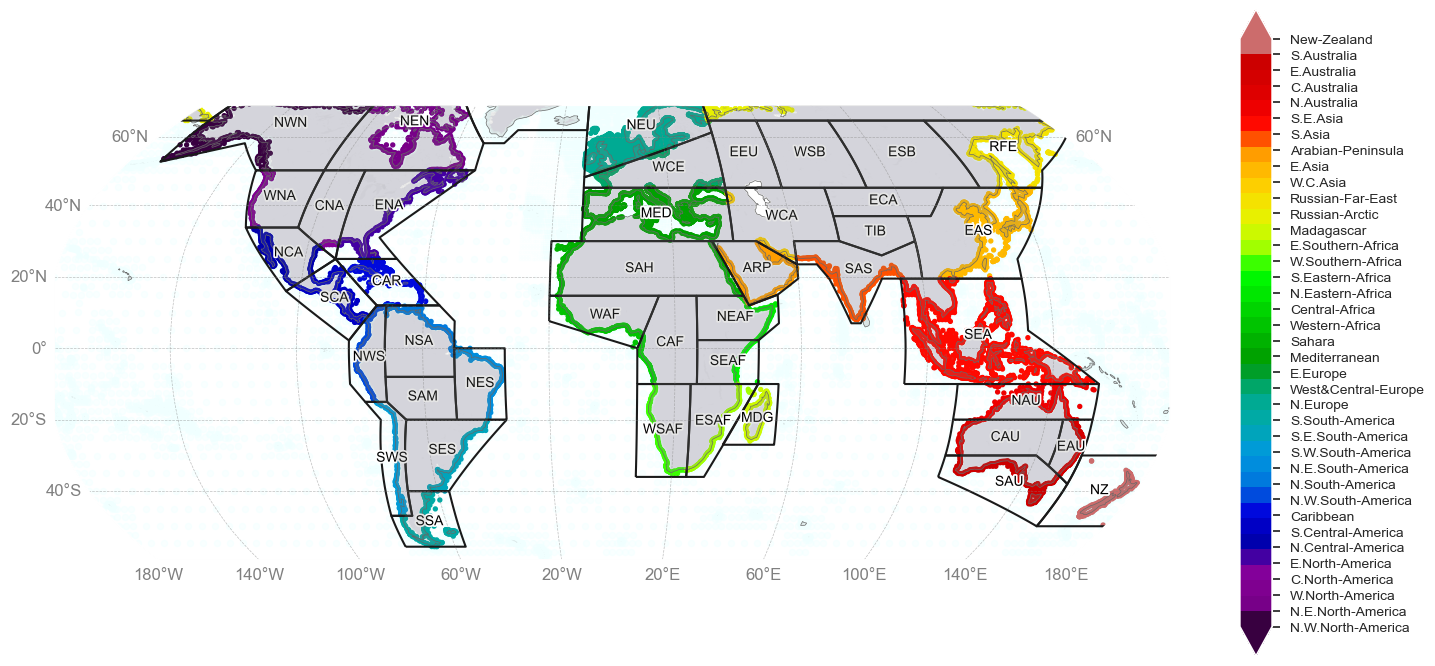

In [8]:
# plot on global map
plot = True
if plot == True:
    crg = crt.crs.PlateCarree() # the one we have defined the data
    crgp = crt.crs.Robinson() # the one to plot the data
    from matplotlib.colors import ListedColormap
    clim=[0,len(regions)] 
    cm = ListedColormap(sns.color_palette('nipy_spectral', len(regions)).as_hex()) 
    
    fig = plt.figure(figsize=(18,14)) 
    ax = fig.add_subplot(111, projection=crt.crs.Robinson()) 
    ax.set_global()
    ax.set_extent([-180, 180, -60, 70], crg)   
    # Identify european coastal points
    lonmin = -35; lonmax = 50;latmin = 20;latmax = 80;depththresh = -20
    ioceaneu = pxyn[(pxyn['bedlevel']<depththresh) &(pxyn['lat']<=latmax)&(pxyn['lat']>=latmin)&(pxyn['lon']>=lonmin)&(pxyn['lon']<=lonmax)].index
    ioceanNeu = pxyn[(pxyn['bedlevel']<depththresh)&((pxyn['lat']>latmax)|(pxyn['lat']<latmin)|(pxyn['lon']<lonmin)|(pxyn['lon']>lonmax))].index
    # Identify coastal points    
    icoast = pxyn[pxyn['bedlevel']>=depththresh].index
    alfaoceaneu = 0.1; alfaoceanNeu = 0.4; alfacoast = 1; psoceaneu = 4; psoceanNeu = 20; pscoast = 8
    # scatter plot
    bs=ax.scatter(x=pxyn.loc[ioceaneu,'lon'].values,y=pxyn.loc[ioceaneu,'lat'].values,alpha=alfaoceaneu,s=psoceaneu,color='azure',transform=crg)
    bs=ax.scatter(x=pxyn.loc[ioceanNeu,'lon'].values,y=pxyn.loc[ioceanNeu,'lat'].values,alpha=alfaoceanNeu,s=psoceanNeu,color='azure',transform=crg)
    bs=ax.scatter(x=pxyn.loc[icoast,'lon'].values,y=pxyn.loc[icoast,'lat'].values,alpha=alfacoast,s=pscoast,color='azure',transform=crg)
    bs=ax.scatter(x=df.loc[:,'lon'].values,y=df.loc[:,'lat'].values,alpha=alfacoast,s=pscoast,c=df.loc[:,'ivalue'].values,cmap=cm,transform=crg,zorder=1)
    # add background       
    ax.add_feature(crt.feature.LAND.with_scale('10m'),facecolor='gray',zorder=4,alpha=0.20)
    ax.add_feature(crt.feature.LAKES.with_scale('10m'), facecolor='gray',zorder=5,alpha=0.05)        
    ax.add_feature(crt.feature.OCEAN.with_scale('10m'), edgecolor='face', facecolor='white')
    # Format lat lon grid    
    gl = ax.gridlines(crs=crg, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.yline = gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlabel_style = {'rotation': 0, 'size': 12, 'color': 'gray'}
    gl.top_labels = gl.right_labels = False
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(-60.,61.,20))
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-180.,181.,40))
    # plot names
    text_kws = dict(bbox=dict(color="none", zorder=101),color="k", fontsize=10,path_effects=[pe.withStroke(linewidth=2.5, foreground="w")],)
    regionmask.defined_regions.ar6.land.plot(ax=ax,text_kws=text_kws, add_ocean=False,label="abbrev")  
    # colorbar
    cbar= plt.colorbar(bs,ax=ax,orientation='vertical',shrink=0.6,extend='both',pad=0.05)
    cbar.set_ticks(np.arange(clim[0],clim[1]))
    cbar.set_ticklabels(regions)  
    cbar.ax.tick_params(labelsize=10)

## Compute ensemble statistics and performance

In [78]:
df_stats = pd.merge(df_changes,df,left_index=True, right_index=True).sort_values(by='Name')

df_melted_abs_change_current = pd.melt(df_stats.filter(regex='abs_change_current|ivalue'),id_vars='ivalue').drop(columns='variable').dropna()
df_melted_abs_change_future = pd.melt(df_stats.filter(regex='abs_change_current|ivalue'),id_vars='ivalue').drop(columns='variable').dropna()
df_melted_rel_change_current = pd.melt(df_stats.filter(regex='abs_change_current|ivalue'),id_vars='ivalue').drop(columns='variable').dropna()
df_melted_rel_change_future = pd.melt(df_stats.filter(regex='abs_change_current|ivalue'),id_vars='ivalue').drop(columns='variable').dropna()

df_melted_abs_change_current.value.describe()


count    117600.000000
mean          0.007770
std           0.068355
min          -2.438000
25%          -0.016000
50%           0.003000
75%           0.027000
max           2.889000
Name: value, dtype: float64

## Create boxplot 

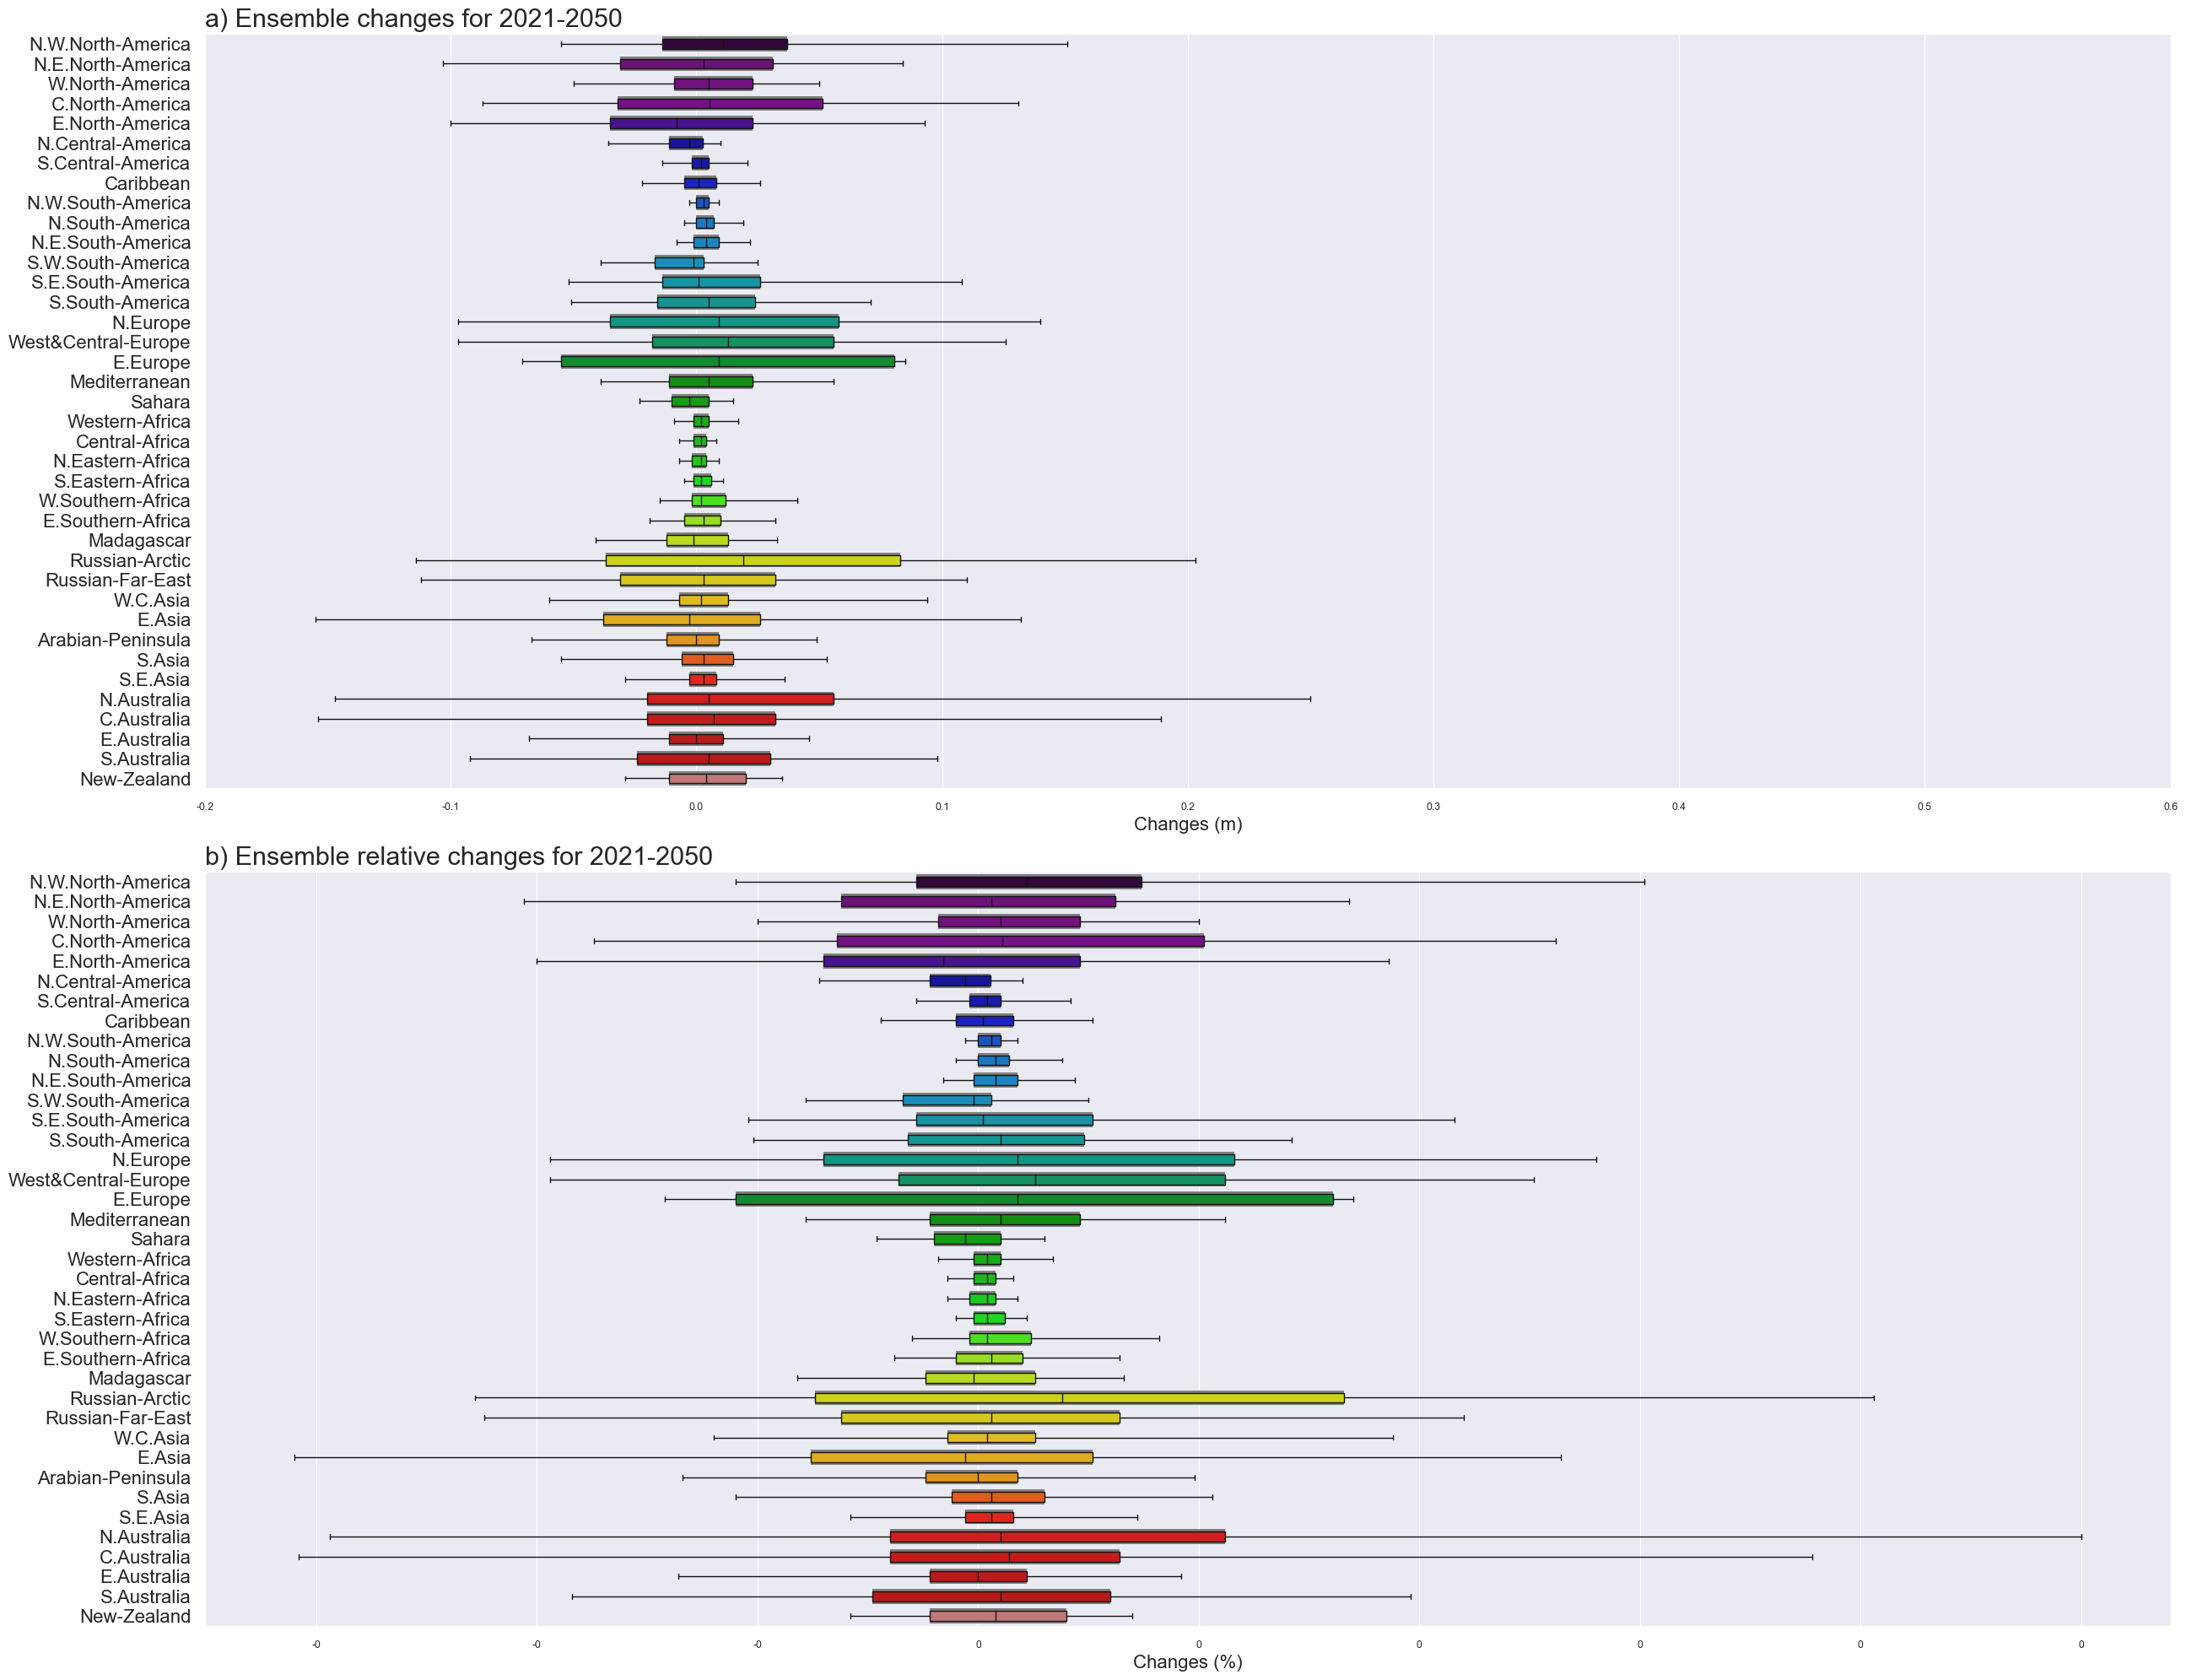

In [86]:
cpal = sns.color_palette('nipy_spectral', len(regions))
sns.set(style="darkgrid", palette="Spectral")  
sns.set_context("paper", font_scale=1.0, rc={"lines.linewidth": 1.0})
flierprops = dict(markerfacecolor='0.4', marker='o',markersize=1,linestyle='none',markeredgecolor=None)
PROPS = {'boxprops':{'facecolor':'gray', 'edgecolor':'None'},'medianprops':{'color':'None'},'whiskerprops':{'color':'None'},'capprops':{'color':'None'}}


fig = plt.figure(figsize=(26,20), tight_layout=True) 
ax = fig.add_subplot(211) 
ax.set_title("a) Ensemble changes for 2021-2050 ", size=22, loc='left')
bxplt = sns.boxplot(ax=ax,y='ivalue',x='value',data=df_melted_abs_change_current,orient="h",showfliers=False, whis=0.,width= 0.75,color='darkgrey',**PROPS)
bxplt = sns.boxplot(ax=ax,y='ivalue',x='value',data=df_melted_abs_change_future,orient="h",flierprops=flierprops,width= 0.5,palette=cpal,whis=[5, 95],showfliers=False)
clim=[-0.2,0.6]
ax.set_xlim(clim[0],clim[1])
ax.set_yticklabels(regions,size = 16)
ax.set_ylabel('')
ax.set_xlabel('Changes (m)', size=16)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax1 = fig.add_subplot(212) 
ax1.set_title("b) Ensemble relative changes for 2021-2050", size=22, loc='left')
bxplt = sns.boxplot(ax=ax1,y='ivalue',x='value',data=df_melted_rel_change_current,orient="h",showfliers=False, whis=0.,width= 0.75,color='darkgrey',**PROPS)
bxplt = sns.boxplot(ax=ax1,y='ivalue',x='value',data=df_melted_rel_change_future,orient="h",flierprops=flierprops,width= 0.5,palette=cpal,whis=[5, 95],showfliers=False)
clim=[-0.2,0.6]
ax.set_xlim(clim[0],clim[1])
ax1.set_yticklabels(regions,size = 16)
ax1.set_ylabel('')
ax1.set_xlabel('Changes (%)', size=16)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))